## Assesing error in EM reconstruction of the MICroNS data set

From https://www.biorxiv.org/content/10.1101/2021.07.28.454025v3.full.pdf we have that

```
"We manually identified synapses in 70 small subvolumes (n=8,611 synapses) distributed across the dataset, giving the automated detection an estimated precision of 96% and recall of 89% (Supplemental Fig 1) with a partner assignment accuracy of 98%."
```

So we generate controls for our metrics where we:

* Remove 4% of the connections; taking into account the precision
* Add 12% ~ 100/0.89 of the connections; taking into account the recall
* Shuffle 2% of the connections; taking into account the partner accuracy

Note that this manipulations overestimate the possible errors, since they are done at the level of connections rather than synapses.

In [1]:
import pickle 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
import sys 
sys.path.append('../../../library')
from structural_basic import load_connectome

In [2]:
# Load pre-computed simplex counts 
root="/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data"
connectomes=["MICrONS",
             "MICrONS_EM_error_precision", 
             "MICrONS_EM_error_recall",
             "MICrONS_EM_error_partner"]
sc, rc ={}, {}
for conn in connectomes:
    with open(f"{root}/{conn}_simplex_counts_.pkl", "rb") as f:
        sc[conn]=pickle.load(f)
    with open(f"{root}/{conn}_count_rc_edges_skeleta_.pkl", "rb") as f:
        rc[conn]=pickle.load(f)

In [3]:
# Font sizes and color schemes and labels
titlesize=8
labelsize=6
ticksize=6
marker_size=2
conversion=2.54
#conversion=1.5


cmap=plt.cm.Dark2
colors={
    'original':'indianred',#cmap(3), 
    'configuration_model':cmap(2), 
    'ER_shuffle':cmap(0), 
    'underlying_model':cmap(4), 
    'bishuffled_model':cmap(5), 
    'run_DD2':"tab:brown",
    "MICrONS":"black",
    "MICrONS_EM_error_precision":"tab:green",
    "MICrONS_EM_error_recall":"tab:gray",
    "MICrONS_EM_error_partner":"tab:pink"}
legend={
    'original':"Original", 
    'configuration_model':"CM", 
    'ER_shuffle':"ER", 
    'underlying_model':"Underlying", 
    'bishuffled_model':"Shuffle", 
    'run_DD2':"Distance"}
markers={
    'original':"o", 
    'configuration_model':"P", 
    'ER_shuffle':"*", 
    'underlying_model':"*", 
    'bishuffled_model':"*", 
    'run_DD2':"H"}

In [4]:
# Plotting functions 
def plot_control(ax, df, key, alpha=0.25, linestyle=None, marker=None,linewidth=None):
    df_mean=df.mean(axis=1).astype(float) 
    err=df.apply(stats.sem,axis=1).to_numpy().astype(float)
    ax.plot(df_mean.index, df_mean, color=colors[key], marker=marker, ms=marker_size,linestyle=linestyle, linewidth=linewidth)
    bottom=df_mean.to_numpy()-err
    top=df_mean.to_numpy()+err
    ax.fill_between(df_mean.index.to_numpy(), bottom, top, alpha=alpha, color=colors[key])

def plot_binary_matrix(N,color,ax):
    from matplotlib import colors as col
    cmap = col.ListedColormap(['none', color])
    bounds=[0,0.5,1]
    norm = col.BoundaryNorm(bounds, cmap.N)
    img = ax.imshow(N, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)
    valmin=0
    n=N.shape[0]
    ax.set_xlim([0,n])
    ax.set_ylim([0,n])
    ax.spines[:].set_color("lightgray")
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def plot_sc_inset(ax, conn, log=True):
    if log:
        ax.set_yscale('log')
    ctr="original"
    ax.plot(sc[conn][ctr], color=colors[ctr], marker=None, linewidth=1)
    ax.set_xticks([sc[conn][ctr].index.min(), sc[conn][ctr].index.max()])
    ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=ticksize)
    ax.minorticks_off()
    for ctr in ['underlying_model','bishuffled_model']:
        df=pd.DataFrame.from_dict(sc[conn][ctr]).fillna(0).astype(int)
        plot_control(ax,df,ctr,alpha=0.5,marker=None, linewidth=0.5, linestyle='dotted')
        ax.spines[["right", "top"]].set_visible(False)    
def plot_rc_violin(ax, conns):
    # Aggreate all into single DataFrame 
    df=[]
    for conn in conns:
        temp=np.reciprocal(pd.DataFrame.from_dict({key:rc_den[conn][key] for key in rc_den[conn] if key!='original'})/
                           rc_den[conn]['original'])
        df.append(temp.rename(columns=legend))
    df=pd.concat(df, axis=1, keys=connectomes)
    # Color dict in seaborn format 
    palette={(conn,legend[ctr]):colors[ctr] for conn in connectomes for ctr in colors.keys()}
    sns.violinplot(df, ax=ax, palette=palette, saturation=0.5, inner=None, linewidth=0)
    ax.set_xticks(range(len(df.columns)), labels=df.columns.get_level_values(level=1))
    ax.tick_params(axis='both', labelsize=labelsize)
    #ax.spines[["right", "bottom"]].set_visible(False)
    ax.spines[:].set_visible(False)
    #ax.xaxis.tick_top()
    
def plot_rc_bar(ax, conns):
    # Aggreate all into single DataFrame 
    df=[]
    for conn in conns:
        temp=np.reciprocal(pd.DataFrame.from_dict({key:rc_den[conn][key] for key in rc_den[conn] if key!='original'})/
                           rc_den[conn]['original'])
        df.append(temp)
    df=pd.concat(df, axis=1, keys=connectomes)
    heights=df.mean(axis=0)
    yerr=df.apply(np.std, axis=0)
    labels=[legend[key] for key in heights.index.get_level_values(level=1)]
    c=[colors[key] for key in heights.index.get_level_values(level=1)]
    ax.bar(x=range(len(heights)), height=heights.to_numpy(), yerr=yerr, color=c)
    ax.set_yticks(np.linspace(1,7, 3))
    ax.spines[:].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(axis='both', labelsize=labelsize)
    ax.set_xticks([])
    #ax.set_xticks(range(len(heights)),labels, rotation=45)
    #ax.legend(ax.patches[0:3], labels[0:3], frameon=False, fontsize=labelsize)
    ax.legend(ax.patches[-3:], labels[-3:], frameon=False, fontsize=labelsize)



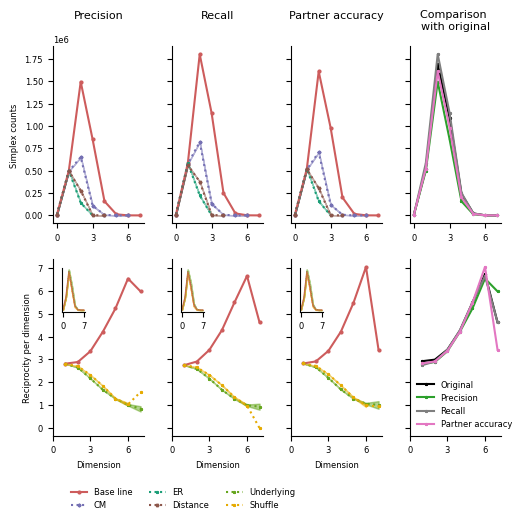

In [5]:
# OPTION 1
width=21*0.7/conversion

fig, axs =plt.subplots(2,4,figsize=(width, width*3.5/4), sharey="row")
titles={"MICrONS":"Original",
        "MICrONS_EM_error_precision":"Precision",
        "MICrONS_EM_error_recall":"Recall",
        "MICrONS_EM_error_partner":"Partner accuracy"}
for ax in axs.flatten():
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.spines[["top", "right"]].set_visible(False)
labels=['Base line']
for j, conn in enumerate(connectomes[1:]):
    axs[0, j].set_title(titles[conn], fontsize=titlesize, y=1.11)
    # Simplex counts 
    i=0
    axs[i,0].set_ylabel("Simplex counts", fontsize=labelsize)
    for ctr in sc[conn].keys():
        #axs[i,j].set_yscale('log')
        if ctr=='original':
            axs[i,j].plot(sc[conn][ctr], color=colors[ctr], marker=markers[ctr],ms=marker_size)
        elif (ctr!='underlying_model') and (ctr!='bishuffled_model'):
            if conn==connectomes[1]: labels+=[legend[ctr]]
            df=pd.DataFrame.from_dict(sc[conn][ctr]).fillna(0).astype(int)
            plot_control(axs[i,j],df,ctr,alpha=0.5, linestyle="dotted", marker=markers[ctr])
        axs[i,j].minorticks_off()

    # Reciprocal connections
    i=1
    axs[i,0].set_ylabel("Reciprocity per dimension", fontsize=labelsize)
    for ctr in rc[conn].keys():
        axs[i,j].set_xlabel('Dimension', fontsize=labelsize)
        if ctr=='original':
            axs[i,j].plot(rc[conn][ctr].index, rc[conn][ctr]['rc/edges_percent'],
                          marker=markers[ctr],ms=marker_size, color=colors[ctr])
        else:
            if conn==connectomes[1]: labels+=[legend[ctr]]
            df=pd.DataFrame.from_dict({key:rc[conn][ctr][key]['rc/edges_percent'] for key in rc[conn][ctr]})
            plot_control(axs[i,j],df, ctr, alpha=0.5, linestyle="dotted", marker=markers[ctr])
    x0, y0, width, height=0.1, 0.7, 0.25, 0.25
    ax=axs[i,j].inset_axes([x0, y0, width, height])
    plot_sc_inset(ax, conn, log=False)


        
# Adding legend
# Get lines 
h1=axs[0,1].get_lines(); h2=axs[1,1].get_lines()[1:]
fig.legend(handles=h1+h2, labels=labels, frameon=False, ncols=3, loc=8, bbox_to_anchor=(0.35,-0.05),fontsize=labelsize)

# Comparing to original 
j=-1
axs[0, j].set_title("Comparison \nwith original", fontsize=titlesize, y=1.05)
for k, conn in enumerate(connectomes[::1]):
    axs[0,-1].plot(sc[conn]["original"], color=colors[conn], marker=markers[ctr],ms=marker_size, label=titles[conn]) 
    axs[1,-1].plot(rc[conn]["original"].index, rc[conn]["original"]['rc/edges_percent'],
                          marker=markers[ctr],ms=marker_size, color=colors[conn], label=titles[conn])
    axs[0,-1].minorticks_off()
    axs[1,-1].minorticks_off()
    axs[1,-1].legend(frameon=False, ncols=1,fontsize=labelsize)


# Fixing tickmark 
for ax in axs.flatten():
    ax.set_xticks([0,3,6])
    ax.tick_params(axis='both', labelsize=ticksize)
    ax.yaxis.get_offset_text().set_fontsize(ticksize)

plt.subplots_adjust(wspace=.3)


fig.savefig("figs/basic_EM_erros_MICrONS.pdf", transparent=True, bbox_inches='tight')

# Stats and counts 

In [6]:
# Edges missing in CM models
edges={}
for conn in connectomes:
    edges[conn]={}
    temp=pd.DataFrame.from_dict(sc[conn]["configuration_model"]).fillna(0).astype(float).loc[1]
    edges[conn]["original"], edges[conn]["mean"], edges[conn]["sem"] = (sc[conn]["original"].loc[1], temp.mean(), stats.sem(temp))
edges=pd.DataFrame.from_dict(edges).T
edges["percent_lost"]=(edges["original"]-edges["mean"])*100/edges["original"]
edges

,original,mean,sem,percent_lost
MICrONS,520477.0,514477.766667,11.223506,1.152641
MICrONS_EM_error_precision,499658.0,494121.400000,12.126214,1.108078
MICrONS_EM_error_recall,582934.0,576751.200000,12.323923,1.060635
MICrONS_EM_error_partner,520477.0,514681.766667,14.215718,1.113447


In [7]:
# Simple counts
pvalues={}
for conn in connectomes:
    pvalues[conn]={}
    for ctr in sc[conn].keys():
        ori=sc[conn]["original"]
        if ctr not in ["original", "underlying_model", "bishuffled_model"]:
            pvalues[conn][ctr]={}
            temp=pd.DataFrame.from_dict(sc[conn][ctr]).fillna(0).astype(float)
            for dim in temp.index[2:]:
                pvalues[conn][ctr][dim]=stats.ttest_1samp(temp.loc[dim], ori.loc[dim], alternative="less").pvalue
    print(f"\n\nFor {conn} the maximum p-value of the 1-sided t-test is {np.nanmax(pd.DataFrame.from_dict(pvalues[conn]))}")

  



For MICrONS the maximum p-value of the 1-sided t-test is 4.688434507976739e-65


For MICrONS_EM_error_precision the maximum p-value of the 1-sided t-test is 2.9461535414006826e-60


For MICrONS_EM_error_recall the maximum p-value of the 1-sided t-test is 2.911119532507613e-66


For MICrONS_EM_error_partner the maximum p-value of the 1-sided t-test is 3.728599717481299e-67
